In [25]:
%pylab inline
import os

rc('font',**{'family':'serif',
             'serif':['Palatino']})
rc('text', **{'usetex': True})

Populating the interactive namespace from numpy and matplotlib


In [26]:
# These scripts are loaded only for the ease of plotting.  They are not essential.
execfile(os.path.join(os.path.expanduser('~/Dropbox/myScripts/'), 'my_script.py'))
execfile(os.path.join(os.path.expanduser('~/Dropbox/myScripts/'), 'long_function_definitions.py'))
mycm = make_my_colormap(c_list=[(0.0, (0.5, 0.0, 0.5)),
                                (0.2, (0.0, 0.0, 1.0)),
                                (0.4, (0.0, 0.8, 1.0)),
                                (0.6, (0.0, 0.8, 0.0)),
                                (0.8, (1.0, 0.8, 0.0)),
                                (1.0, (1.0, 0.0, 0.0))])
#savefig_dir = '/Users/fdu/Dropbox/work/myPapers/untitled_20140326/figures/'
#rcParams['axes.color_cycle'] = mycolors
#print mycolors

**We stick to SI units unless otherwised stated.**

In [27]:
def calc_f_drag(lam, s, rho, v, v_thermal, C_D):
    """
    lam: mean free path of the gas molecules
    s: radius of the solid particle
    rho: gas mas density
    v: velocity of the solid particle
    v_thermal: thermal velocity of the gas molecules
    C_D: drag coefficient
    Ref: Weidenschilling 1977
    """
    return where(9.0*lam < 4.0*s,
                 C_D * pi * s**2 * rho * v**2 * 0.5,
                 4.0*pi/3.0 * s**2 * rho * v * v_thermal) # Epstein

def calc_C_D(Re):
    """
    Return the dimensionless drag coefficient
    Re: Reynolds number
    """
    return where(Re < 1.0,
                 24.0 / Re, # Stokes' law
                 where(Re < 800.0,
                       24.0 * pow(Re, -0.6),
                       0.4348677982066174))

def calc_Reynolds(s, rho, v, eta):
    """
    Return the Reynolds number
    """
    return 2.0 * s * rho * v / eta

def calc_mean_free_path(eta, rho, v_thermal):
    """
    Return the mean free path
    Ref: http://en.wikipedia.org/wiki/Viscosity#Relation_to_mean_free_path_of_diffusing_particles
    """
    return 2.0 * eta / (rho * v_thermal)

def calc_v_thermal(m, T):
    k = 1.3806503e-23
    return sqrt(8.0/pi * k * T / m)

def calc_acc_gravity_z(M, r, z):
    G = 6.67428e-11
    return -G * M * z / r**3

def calc_eta_vicosity(T):
    """
    Ref: http://www.astronomy.ohio-state.edu/~ryden/ast825/ch2-3.pdf
    """
    return 2e-5 * sqrt(T/3e2)

def calc_adsorption_growth_by_gas(n_gas, X, v_thermal, vol_per_mol):
    '''
    Return ds/dt, the rate of change of the size of a grain by adsorption of gas molecules
    '''
    return 0.25 * vol_per_mol * v_thermal * n_gas * X

def calc_adsorption_losing_rate(n_gas, X, v_thermal, s):
    return pi * s*s * v_thermal * n_gas * X

def calc_eom(r, z, v, s, m_dust, m_gas, T_gas, calc_rho_gas, M):
    '''
    Equation of motion
    d/dt v = calc_eom()
    '''
    
    rho_gas = calc_rho_gas(r, z)

    eta = calc_eta_vicosity(T_gas)
    
    v_thermal = calc_v_thermal(m_gas, T_gas)
    
    lam = calc_mean_free_path(eta, rho_gas, v_thermal)
    
    Re = calc_Reynolds(s, rho_gas, v, eta)
    
    C_D = calc_C_D(Re)
    
    f_g = calc_acc_gravity_z(M, r, z)
    f_f = -sign(v) * calc_f_drag(lam, s, rho_gas, v, v_thermal, C_D) / m_dust
    
    return f_g + f_f

def calc_eom_vec(zv):
    return array((zv[1],
                  calc_eom(r, zv[0], zv[1], )))

In [28]:
def calc_sedimentation_time(Mstar_in_Msun, R_in_AU, sig_dust, m_dust, rho_gas, v_T):
    G = 6.67428e-11
    M_sun = 1.9891e30
    AU = 1.5e11
    return 4.0/3.0 * rho_gas * v_T * sig_dust \
           / (G*Mstar_in_Msun*M_sun/(R_in_AU*AU)**3 * m_dust)

In [29]:
def calc_t_scales(r_dust_micron, n_gas_CGS=1e9, d2g_mass=1e-2, T=1e2, M_star=1.0, R_AU=1.0,
                  X_metal=1e-4, d_dust_crystal=1e-10):
    k = 1.38e-23
    year_in_seconds = 3.15e7
    rho_dust_material = 2.0e3
    #
    r_dust = r_dust_micron * 1e-6
    sig_dust = pi * r_dust**2
    m_dust = 4.0*pi/3.0 * r_dust**3 * rho_dust_material
    #
    n_gas = n_gas_CGS * 1e6
    rho_gas = n_gas * 1.67e-27
    d2g_num = d2g_mass * 1.67e-27 / m_dust
    n_dust = n_gas * d2g_num
    #
    v_T = sqrt(8.0*k*T/(pi*1.67e-27))
    #
    G = 6.67428e-11
    M_sun = 1.9891e30
    AU = 1.5e11
    t_orb = 2*pi / sqrt(G*M_star*M_sun/(R_AU*AU)**3) / year_in_seconds
    #
    t_sed = calc_sedimentation_time(M_star, R_AU, sig_dust, m_dust, rho_gas, v_T) / year_in_seconds
    t_ads = 1.0 / (sig_dust * v_T * n_dust) / year_in_seconds
    t_gro = r_dust / (n_gas * X_metal * v_T * d_dust_crystal**3) / year_in_seconds
    #
    num_ads = t_sed * year_in_seconds * sig_dust * v_T * X_metal * n_gas * n_dust
    #
    return t_sed, t_ads, t_gro, t_orb, num_ads

In [30]:
def calc_r_grow_rate(n_gas, X_Metal, v_T, d_crystal):
    return n_gas * X_Metal * v_T * d_crystal**3

In [36]:
def calc_t_decay(t_sed, t_orb):
    Delta = t_sed**2 - 4.0 * t_orb**2
    return where(Delta<=0.0,
          2.0*t_orb**2/t_sed,
          0.5 * (t_sed + sqrt(Delta)))

/Users/fjdu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


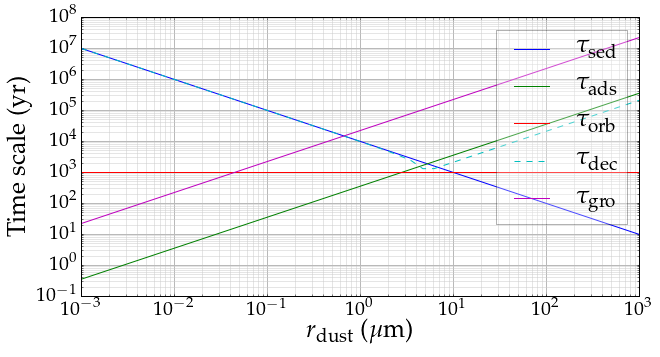

In [38]:
r_s = logspace(-3,3)
t_sed, t_ads, t_gro, t_orb, num_ads = calc_t_scales(r_s, n_gas_CGS=1e7, R_AU=1e2)
t_dec = calc_t_decay(t_sed, t_orb)

figure(figsize=(10,5))
plot(r_s, t_sed, label=r'$\tau_{\rm sed}$')
plot(r_s, t_ads, label=r'$\tau_{\rm ads}$')
plot(r_s, r_s*0+t_orb, label=r'$\tau_{\rm orb}$')
plot(r_s, t_dec, label=r'$\tau_{\rm dec}$', linestyle='--')
plot(r_s, t_gro, label=r'$\tau_{\rm gro}$')
#plot(r_s, num_ads, label=r'$N_{\rm ads}$')
ax = gca()
ax.set_xlabel(r'$r_{\rm dust}$ ($\mu$m)')
ax.set_ylabel(r'Time scale (yr)')
ax.set_xscale('log')
ax.set_yscale('log')
set_axis_format(ax, graygrid=True)
_ = legend(fontsize=25, framealpha=0.3)

/Users/fjdu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


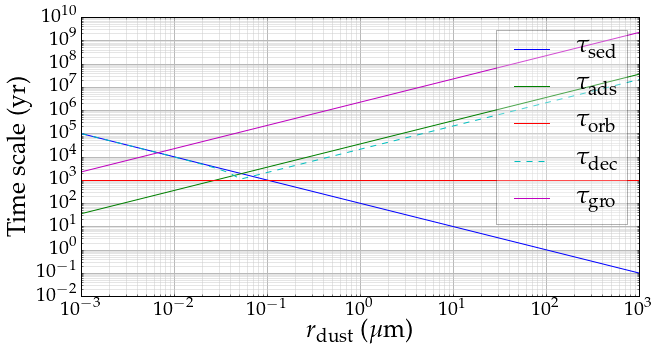

In [40]:
r_s = logspace(-3,3)
t_sed, t_ads, t_gro, t_orb, num_ads = calc_t_scales(r_s, n_gas_CGS=1e5, R_AU=1e2)
t_dec = calc_t_decay(t_sed, t_orb)

figure(figsize=(10,5))
plot(r_s, t_sed, label=r'$\tau_{\rm sed}$')
plot(r_s, t_ads, label=r'$\tau_{\rm ads}$')
plot(r_s, r_s*0+t_orb, label=r'$\tau_{\rm orb}$')
plot(r_s, t_dec, label=r'$\tau_{\rm dec}$', linestyle='--')
plot(r_s, t_gro, label=r'$\tau_{\rm gro}$')
#plot(r_s, num_ads, label=r'$N_{\rm ads}$')
ax = gca()
ax.set_xlabel(r'$r_{\rm dust}$ ($\mu$m)')
ax.set_ylabel(r'Time scale (yr)')
ax.set_xscale('log')
ax.set_yscale('log')
set_axis_format(ax, graygrid=True)
_ = legend(fontsize=25, framealpha=0.3)

In [64]:
n_gas = 1.0e9 * 1e6
X_Metal = 1.0e-4
v_T = 1e3
d_crystal = 1e-10
rr = 1e-6
print rr/calc_r_grow_rate(n_gas, X_Metal, v_T, d_crystal)/3.15e7

317.46031746


In [121]:
import scipy.constants as const

M_sun = 1.9891e30
rho_dust_material = 3.0e3 # kg m-3
M = 0.6 * M_sun
r = 10.0 * const.au
z = 1.0 * const.au

v = 1.0
T_gas = 3.0e2
n_gas = 1.0e9 * 1e6
X = 1.0e-4

s = 0.1 * const.micron
m_dust = rho_dust_material * (4.0*pi/3.0*s**3)
m_gas = 2.0 * const.m_p

def calc_rho_gas(r,z):
    return n_gas * m_gas

In [123]:
v_thermal = calc_v_thermal(m_gas, T_gas)
vol_per_mol = (const.angstrom*2.8)**3

print calc_adsorption_growth_by_gas(n_gas, X, v_thermal, vol_per_mol) * const.year * 1.0e6
r_los = calc_adsorption_losing_rate(n_gas, X, v_thermal, s)
print r_los
print 1e12 * X / r_los / (const.year * 1.0e6)

0.030731189361
5.57838560807
5.68440301758e-07


In [129]:
eta = calc_eta_vicosity(T_gas)
rho_gas = n_gas * m_gas

Re = calc_Reynolds(s, rho_gas, v, eta)
C_D = calc_C_D(Re)

lam = calc_mean_free_path(eta, rho_gas, v_thermal)

k1 = calc_f_drag(lam, s, rho, v, v_thermal, C_D) / m_dust / v
tau1 = 1/k1
tau2 = -k1 / calc_acc_gravity_z(M, r, z)
tau3 = 2.0*pi/sqrt(-calc_acc_gravity_z(M, r, z))
print tau1/const.year, tau2/const.year, tau3/const.year

0.00160150480572 1.76399387944e-07 0.000105606956891


In [130]:
v_s = -calc_acc_gravity_z(M, r, z) / (calc_f_drag(lam, s, rho, v, v_thermal, C_D) / m_dust / v)
print v_s, z/v_s/const.year

0.17976134925 26388.9728276


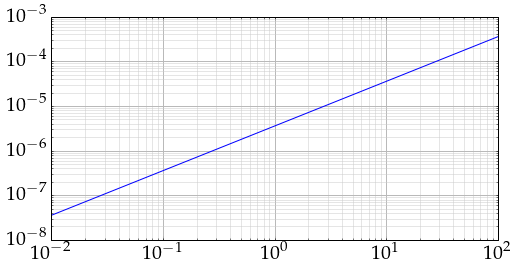

In [58]:
z = logspace(-2,2) * const.au
acc = calc_eom(r, z, v, s, m_dust, m_gas, T_gas, calc_rho_gas, M)
quick_plot(z/const.au, -acc)

In [131]:
def quick_plot(x,y):
    def get_scale(v):
        vmax = max(v)
        vmin = min(v)
        if vmax*vmin > 0.0:
            if vmax / vmin > 20.0:
                return 'log'
            else:
                return 'linear'
        else:
            return 'linear'
    fsize = (8,4)
    figure(figsize=fsize)
    plot(x, y)
    ax = gca()
    ax.set_xscale(get_scale(x))
    ax.set_yscale(get_scale(y))
    set_axis_format(ax, graygrid=True)

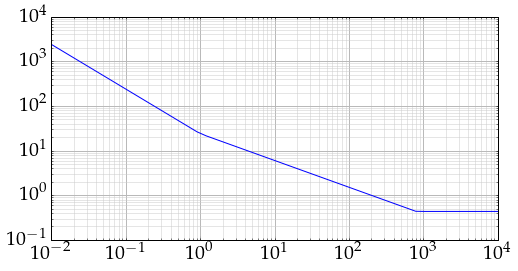

In [133]:
Re = logspace(-2,4)
C = calc_C_D(Re)

quick_plot(Re, C)

In [135]:
#1503  51 2127.682400 3.049E-19 1.945E+01.06760.075   38.44810.74-.003090              1              0                    P  4      467663 2 2 2 2 1 1     7.0    9.0
print 1/4.7e-4, 1/2127.682400

2127.65957447 0.000469994957894
